In [2]:
import numpy as np
import io_subs
import importlib
importlib.reload(io_subs)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyresample import image, geometry
import lkTables

lookupT=lkTables.scattTables()

import xarray as xr

import glob

f2BCMB=glob.glob('/Volumes/T7 Shield/SUBSETS/Subsets/2B-CS-CONUS*')
f2BCMB=sorted(f2BCMB)
f2ADPR=glob.glob('/Volumes/T7 Shield/SUBSETS/Subsets/2A-CS-CONUS*DPR*')
f2ADPR=sorted(f2ADPR)
print(len(f2BCMB),len(f2ADPR))

658 653


In [72]:
ntot=0
import netCDF4 as nc
def readCMB_ptype(fname): # reads relevant data from the CMB file
    fh_cmb=nc.Dataset(fname)
    pType=fh_cmb["KuKaGMI/Input/precipitationType"][:,:]  
    zeroDegAltitude=fh_cmb["KuKaGMI/Input/zeroDegAltitude"][:,:]
    return pType,zeroDegAltitude,fh_cmb
zeroDegAltL=[]
zMeasL=[]
bcfL=[]
bsfcL=[]
bzdL=[]
pFlagL=[]
PIAhybridL=[]
bbFlagL=[]
dmL=[]
pRateL=[]
nearSfcPrecipL=[]
pTypeL=[]
piaFinalL=[]
reliabFL=[]
p1L=[]
p2L=[]
p3L=[]
ifile=0
zeta1L=[]
zeta2L=[]
piaCMB_nohbL=[]
piaCMBL=[]


for f in f2BCMB:
    ifile+=1
    pType,zeroDegAlt,fh_cmb=readCMB_ptype(f)
    pType=np.array(pType/1e7,dtype=int)
    nearSfcPrecip=fh_cmb["KuKaGMI/nearSurfPrecipTotRate"][:,:]
    piaCMB=fh_cmb["KuKaGMI/pia"][:,:]
    orb=f.split('.')[-3]
    for f2 in f2ADPR:
        if orb in f2:
            break
    if orb not in f2:
        print('No match for ',orb)
        continue
    #print(f,f2)
    a=np.where(pType>0)
    fDPR=nc.Dataset(f2)
    zMeas=fDPR["FS/PRE/zFactorMeasured"]
    bcf=fDPR["FS/PRE/binClutterFreeBottom"]
    bsfc=fDPR["FS/PRE/binRealSurface"]
    bzd=fDPR["FS/VER/binZeroDeg"]
    pFlag=fDPR["FS/PRE/flagPrecip"]
    PIAhybrid=fDPR["FS/SRT/PIAhybrid"]
    piaFinal=fDPR["FS/SLV/piaFinal"]
    reliabF=fDPR["FS/SRT/reliabFlag"]
    bbFlag=fDPR["FS/CSF/flagBB"]
    ncmb=pType.shape[0]
    ndpr=zMeas.shape[0]
    
    if ncmb!=ndpr:
        print('Mismatch in number of scans')
        continue
    a=np.where(pType==2)
    dn=2
    beta=0.73
    q=0.2*np.log(10)
    dr=0.125
    attRCoeffs=np.array([ 0.73007628, -3.43508035])
    attGCoeffs=np.array([ 0.73, -4.8185116])
    attMCoeffs=np.array([ 0.7711885 , -3.79301267])
    zetamax=1.-10**(-10/10.*beta)
    #print(len(a[0]))
    for i in range(len(a[0])):
        if a[0][i]>dn and a[0][i]<pType.shape[0]-dn and a[1][i]>12 and a[1][i]<pType.shape[1]-12:
            zKu1=zMeas[a[0][i],a[1][i],:,0]
            i0,j0=a[0][i],a[1][i]
            zeta1=np.sum(10**(0.1*beta*zKu1[:bzd[i0,j0]])*dr*10**attGCoeffs[1])
            zeta2=np.sum(10**(0.1*beta*zKu1[bzd[i0,j0]:bcf[i0,j0]])*dr*10**attRCoeffs[1])
            #zetaL.append(q*beta*(zeta1+zeta2))
            zeta=list(10**(0.1*beta*zKu1[:bzd[i0,j0]])*dr*10**attGCoeffs[1])
            zeta.extend(list(10**(0.1*beta*zKu1[bzd[i0,j0]:bcf[i0,j0]])*dr*10**attRCoeffs[1]))
            zeta=q*beta*np.array(zeta).cumsum()
            zeta=10**(0.5*(1-beta))*np.array(zeta)
            dm=fh_cmb["KuKaGMI/precipTotDm"][i0,j0,:]
            pRate=fh_cmb["KuKaGMI/precipTotRate"][i0,j0,:]
            if zeta[-1]>zetamax:
                bcfL.append(bcf[i0,j0])
                bsfcL.append(bsfc[i0,j0])
                bzdL.append(bzd[i0,j0])
                zMeasL.append(zMeas[a[0][i],a[1][i],:])
                zeroDegAltL.append(zeroDegAlt[i0,j0])
                PIAhybridL.append(PIAhybrid[i0,j0])
                piaFinalL.append(piaFinal[i0,j0])
                piaCMB_nohbL.append(piaCMB[i0,j0])
                dmL.append(dm)
                pRateL.append(pRate)
                zeta1L.append(zeta1)
                zeta2L.append(zeta2)
            else:
                #print(PIAhybrid[i0,j0],-10/beta*np.log10(1-zeta[-1]))
                p1L.append(PIAhybrid[i0,j0,0])
                p2L.append(-10/beta*np.log10(1-zeta[-1]))
                p3L.append(piaFinal[i0,j0,0])
                piaCMBL.append(piaCMB[i0,j0])
                reliabFL.append(reliabF[i0,j0])
    print('ifile=',ifile,len(zMeasL),np.corrcoef(p1L,p2L))
    if len(zMeasL)>3000:
        break
    

ifile= 1 0 [[1.         0.91667071]
 [0.91667071 1.        ]]
ifile= 2 0 [[1.         0.80236953]
 [0.80236953 1.        ]]
ifile= 3 0 [[1.         0.80236953]
 [0.80236953 1.        ]]
ifile= 4 0 [[1.        0.8759506]
 [0.8759506 1.       ]]
ifile= 5 0 [[1.         0.87357985]
 [0.87357985 1.        ]]
ifile= 6 0 [[1.         0.87357985]
 [0.87357985 1.        ]]
ifile= 7 2 [[1.         0.71241837]
 [0.71241837 1.        ]]
ifile= 8 3 [[1.         0.70985861]
 [0.70985861 1.        ]]
ifile= 9 3 [[1.         0.71055954]
 [0.71055954 1.        ]]
ifile= 10 3 [[1.         0.71065224]
 [0.71065224 1.        ]]
ifile= 11 3 [[1.         0.71065224]
 [0.71065224 1.        ]]
ifile= 12 3 [[1.         0.71242903]
 [0.71242903 1.        ]]
ifile= 13 63 [[1.         0.82284633]
 [0.82284633 1.        ]]
ifile= 14 63 [[1.         0.82284633]
 [0.82284633 1.        ]]
ifile= 15 63 [[1.         0.82515721]
 [0.82515721 1.        ]]
ifile= 16 75 [[1.        0.7895402]
 [0.7895402 1.       ]]
ifile

In [71]:
import xarray as xr
pRateX=xr.DataArray(np.array(pRateL),dims=['n','nlev2'])
dmX=xr.DataArray(np.array(dmL),dims=['n','nlev2'])
zMeasX=xr.DataArray(np.array(zMeasL),dims=['n','nlev','nbin'])
bcfX=xr.DataArray(np.array(bcfL),dims=['n'])
bsfcX=xr.DataArray(np.array(bsfcL),dims=['n','n2'])
bzdX=xr.DataArray(np.array(bzdL),dims=['n'])
zeroDegAltX=xr.DataArray(np.array(zeroDegAltL),dims=['n'])
PIAhybridX=xr.DataArray(np.array(PIAhybridL),dims=['n','n2'])
piaFinalX=xr.DataArray(np.array(piaFinalL),dims=['n','n2'])
piaCMB_nohbX=xr.DataArray(np.array(piaCMB_nohbL),dims=['n','n2'])
zeta1X=xr.DataArray(np.array(zeta1L),dims=['n'])
zeta2X=xr.DataArray(np.array(zeta2L),dims=['n'])
ds=xr.Dataset({'pRate':pRateX,'dm':dmX,'zMeas':zMeasX,'bcf':bcfX,'bsfc':bsfcX,'bzd':bzdX,'zeroDegAlt':zeroDegAltX,'PIAhybrid':PIAhybridX,'piaFinal':piaFinalX,'piaCMB_nohb':piaCMB_nohbX,'zeta1':zeta1X,'zeta2':zeta2X})
compressLev={'zlib':True,'complevel':5}
encoding={'pRate':compressLev,'dm':compressLev,'zMeas':compressLev,'bcf':compressLev,'bsfc':compressLev,'bzd':compressLev,'zeroDegAlt':compressLev,'PIAhybrid':compressLev,'piaFinal':compressLev,'piaCMB_nohb':compressLev,'zeta1':compressLev,'zeta2':compressLev}
ds.to_netcdf('2BCMB_2ADPR_noHB.nc',encoding=encoding)

74991 [[1.         0.75635219]
 [0.75635219 1.        ]]
0.6564914 0.9618627220222541 1.1471684 1.1732991
74991 bm 0.756352188550031 0.9129073671440237
[[1.         0.71612656]
 [0.71612656 1.        ]]
bs [[1.         0.78598528]
 [0.78598528 1.        ]]
fract= 0.026096464909122426
[[1.         0.62662782]
 [0.62662782 1.        ]]


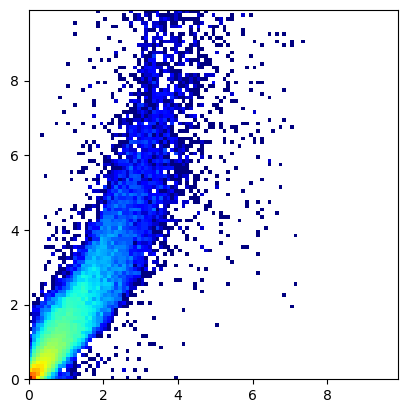

In [63]:
print(len(p1L),np.corrcoef(p1L,p2L))
piaCMBL=np.array(piaCMBL)
from matplotlib.colors import LogNorm
ax=plt.subplot(111)
h1=plt.hist2d(p1L,p3L,bins=np.arange(0,10,0.1),cmap='jet',norm=LogNorm())
ax.set_aspect('equal')
print(np.mean(p1L),np.mean(p2L),np.mean(p3L),np.mean(piaCMBL[:,0]))
print(len(p1L),'bm',np.corrcoef(p1L,p2L)[0,1],np.corrcoef(p2L,piaCMBL[:,0])[0,1])
print(np.corrcoef(p2L,p3L))
print('bs',np.corrcoef(p1L,p3L))
#plt.scatter(p1L,p2L)
print('fract=',len(zMeasL)/len(p1L))
reliabFL=np.array(reliabFL)
p1L=np.array(p1L)
p2L=np.array(p2L)
p3L=np.array(p3L)
a=np.where(reliabFL==1)

print(np.corrcoef(p1L[a],p2L[a]))

1957 74991 74991 74991
9.453163
[[1.         0.38455122]
 [0.38455122 1.        ]] [[1.         0.54339102]
 [0.54339102 1.        ]]
9.453163 3.007306 8.930847


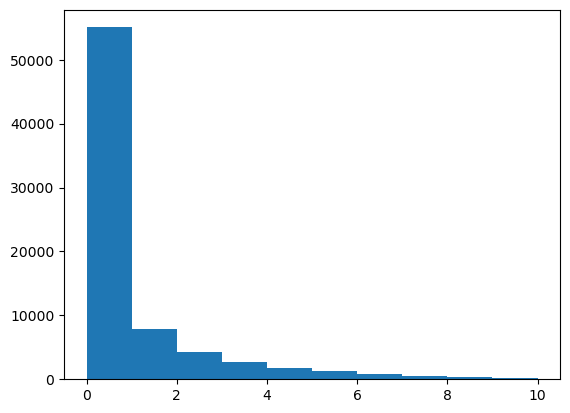

In [66]:
#print(pType[a])
print(len(zMeasL),len(p1L),len(p2L),len(p3L))
plt.hist(p2L)
print(np.array(piaFinalL)[:,0].mean())
print(np.corrcoef(np.array(piaFinalL)[:,0],np.array(PIAhybridL)[:,0]),np.corrcoef(np.array(piaFinalL)[:,0],np.array(piaCMB_nohbL)[:,0]))
print(np.array(piaFinalL)[:,0].mean(),np.array(PIAhybridL)[:,0].mean(),np.array(piaCMB_nohbL)[:,0].mean()) 

In [5]:
import xarray as xr
zMeasX=xr.DataArray(np.array(zMeasL),dims=['n','nw','nbin','nchan'])
zeroDegAltX=xr.DataArray(np.array(zeroDegAltL),dims=['n','nw'])
bcfX=xr.DataArray(np.array(bcfL),dims=['n','nw'])
bsfcX=xr.DataArray(np.array(bsfcL),dims=['n','nw','nchan'])
bzdX=xr.DataArray(np.array(bzdL),dims=['n','nw'])
pFlagX=xr.DataArray(np.array(pFlagL),dims=['n','nw'])
bbFlagX=xr.DataArray(np.array(bbFlagL),dims=['n','nw'])
dmX=xr.DataArray(np.array(dmL),dims=['n','nw','nbin2'])
pRateX=xr.DataArray(np.array(pRateL),dims=['n','nw','nbin2'])
PIAhybridX=xr.DataArray(np.array(PIAhybridL),dims=['n','nw','nchan'])
nearSfcPrecipX=xr.DataArray(np.array(nearSfcPrecipL),dims=['n','nw'])
pTypeX=xr.DataArray(np.array(pTypeL),dims=['n','nw'])
ds=xr.Dataset({'zMeas':zMeasX,'bcf':bcfX,'bsfc':bsfcX,'bzd':bzdX,'pFlag':pFlagX,'bbFlag':bbFlagX,'dm':dmX,'pRate':pRateX,'zeroDegAlt':zeroDegAltX,'PIAhybrid':PIAhybridX,'nearSfcPrecip':nearSfcPrecipX,'pType':pTypeX})
compres={'zlib':True,'complevel':5}
encoding={'zMeas':compres,'bcf':compres,'bsfc':compres,'bzd':compres,'pFlag':compres,'bbFlag':compres,'dm':compres,'pRate':compres,'zeroDegAlt':compres,'PIAhybrid':compres,'nearSfcPrecip':compres}
ds.to_netcdf('dpr_cmb_all.nc',encoding=encoding)


In [59]:
#define a feedforward neural network in torch with 2 hidden layers

import torch
import torch.nn as nn
import torch.nn.functional as F

class projNet(nn.Module):
    def __init__(self, nin, nout, nh):
        super(projNet, self).__init__()
        self.nin=nin
        self.nout=nout
        self.nh=nh
        self.fc1 = nn.Linear(nin, nh)
        self.fc2 = nn.Linear(nh, nh)
        self.fc3 = nn.Linear(nh, nout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

projOperator=projNet(3,64,32)
xin=torch.randn(10,32,3)
yout=projOperator(xin.view(-1,3))

In [65]:
from neuralop.models import FNO

model_fno = FNO(n_modes=(16, 8), hidden_channels=32,
                in_channels=5, out_channels=2)

xin=torch.randn(10,5,32,64)
yout=model_fno(xin)
print(yout.shape)

torch.Size([10, 2, 32, 64])
